In [1]:
name_subj = "B2_EEG"

import mne
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
EEG_data_path = '../data/B2/'#Path data is


# Reading raw BDF, setting up bipolar references and montage

In [2]:
raw = mne.io.read_raw_bdf(EEG_data_path+'%s.bdf'%name_subj,preload=True, verbose=True)

Extracting EDF parameters from /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/data/B2/B2_EEG.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5441535  =      0.000 ...  2657.000 secs...


In [3]:
raw.info

Measurement date,"May 30, 2024 11:01:03 GMT"
Experimenter,Unknown
Participant,B22
Digitized points,Not available
Good channels,"72 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,417.00 Hz


- Good channels : 72 electrodes total (including the extrenal ones) + 1 stimulus (the trigger channel)

- Bad channels can be completed if needed

- EOG will be

- ECG is used in MEG

In [5]:
#raw.pick_channels(['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz','EXG1','EXG2','EXG3','EXG4','Status'])
# Creating the bipolar montage, the 4 first are the EOG
# ???? mne.set_bipolar_reference(raw,anode=['EXG1','EXG3'],cathode=['EXG2','A1'],ch_name=['EOGH','EOGV'],copy=False, drop_refs=False) 
raw.drop_channels(['EXG5','EXG6','EXG7', 'EXG8'])#Empty
raw.set_channel_types({'EXG1':'eog','EXG2':'eog','EXG3':'misc','EXG4':'misc'})#declare type to avoid confusion with EEG channels
raw.set_montage('biosemi64')

/tmp/ipykernel_5047/3219339146.py:5: RuntimeWarning: The unit for channel(s) EXG3, EXG4 has changed from V to NA.
  raw.set_channel_types({'EXG1':'eog','EXG2':'eog','EXG3':'misc','EXG4':'misc'})#declare type to avoid confusion with EEG channels


Measurement date,"May 30, 2024 11:01:03 GMT"
Experimenter,Unknown
Participant,B22
Digitized points,67 points
Good channels,"64 EEG, 2 EOG, 2 misc, 1 Stimulus"
Bad channels,None
EOG channels,"EXG1, EXG2"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,417.00 Hz


In [7]:
raw.info["Participant"]

KeyError: 'Participant'

# Checking for bad electrodes

In [8]:
%matplotlib qt
# Double click on electrode, it gets grey and is added to 'bad channels' 
# In the interactive plot 'Status' is the trigger channel
raw.plot(block=True, scalings=100e-6);

Using qt as 2D backend.
Channels marked as bad:
none


# Referencing

In [9]:
# Ref to the average
raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Measurement date,"mai 30, 2024 11:01:03 GMT"
Experimenter,Unknown
Participant,B22
Digitized points,67 points
Good channels,"64 EEG, 2 EOG, 2 misc, 1 Stimulus"
Bad channels,None
EOG channels,"EXG1, EXG2"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,417.00 Hz


# Filtering

High pass filter

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.01 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Filter length: 675841 samples (330.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    8.6s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_5047/3420238711.py:7: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd(tmin=500, fmax=200, picks='eeg'); # fmax to 200 when not as downsampled
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


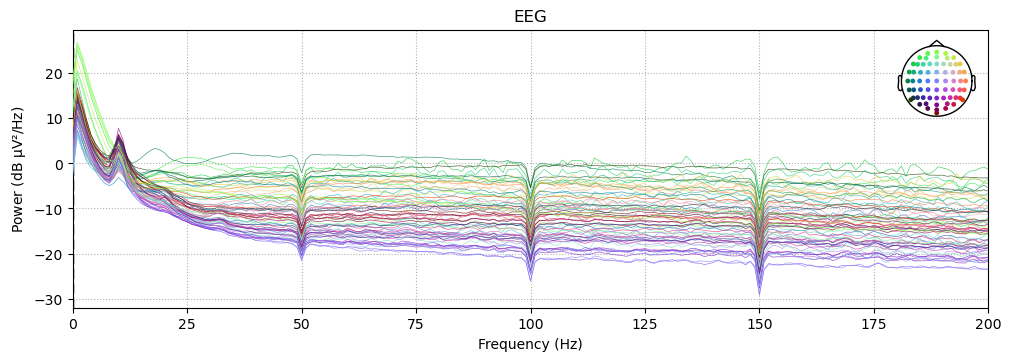

In [10]:
%matplotlib inline 
#bandpass filter
raw.filter(l_freq =.01, h_freq = None,l_trans_bandwidth='auto',filter_length='auto',phase='zero') # high-pass filter to keep >.01 Hz
#Against electric noise of 50hz
raw.notch_filter(freqs=[50,100,150]) # add 150 when less downsampled
# Fourier to check filtering
raw.plot_psd(tmin=500, fmax=200, picks='eeg'); # fmax to 200 when not as downsampled
plt.show()

In [12]:
# save in case of crash
raw.save(EEG_data_path+"preprocessing/pre_rejection_%s.fif"%name_subj,overwrite=True) 

Writing /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/notebooks/../data/B2/preprocessing/pre_rejection_B2_EEG.fif


/tmp/ipykernel_5047/1446159806.py:2: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/notebooks/../data/B2/preprocessing/pre_rejection_B2_EEG.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(EEG_data_path+"preprocessing/pre_rejection_%s.fif"%name_subj,overwrite=True)


Closing /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe2/notebooks/../data/B2/preprocessing/pre_rejection_B2_EEG.fif
[done]


# Rejecting artefacts

In [ ]:
raw = mne.io.read_raw_fif(EEG_data_path+"preprocessing/pre_rejection_%s.fif"%name_subj)

In [ ]:
events = mne.find_events(raw, shortest_event=1)
mne.viz.plot_events(events);

In [ ]:
start_weird = events[events[:,-1] == 256][0][0]#start time of weird triggers
events = events[events[:,0] < start_weird]

In [ ]:
stim_trigger = [5]
cue_trigger = [3]
resp_trigger = [4]
stim = np.array([x for x in events if x[-1] in  cue_trigger])
resp = np.array([x for x in events if x[-1] in  resp_trigger])


## Annotation of very long RTs

In [ ]:
stim_events = np.array([list(x) for x in events if x[2] in cue_trigger])


estimated_duration_breaks = 5 #seconds
onset_breaks = stim_events[np.where(np.diff(stim_events[:,0], n=1) > (raw.info['sfreq']*estimated_duration_breaks))][:,0]/raw.info['sfreq'] #detecting latencies between triggers > x sec
offset_breaks = np.flip(np.flip(stim_events)[np.where(np.diff(np.flip(stim_events[:,0]), n=1) < -(raw.info['sfreq']*estimated_duration_breaks))])[:,0]/raw.info['sfreq']

onset_breaks = onset_breaks + 3 #add 3 sec after last stimulus trigger
offset_breaks = offset_breaks - .6 #removes 600 msec before next stimulus trigger

onset_breaks = np.insert(onset_breaks,0,0)#just adding start of the recording to the breaks
onset_breaks = np.insert(onset_breaks,-1, stim_events[-1,0]/raw.info['sfreq']+3)#just adding end of the recording to the breaks

offset_breaks = np.insert(offset_breaks,0,stim_events[0,0]/raw.info['sfreq']-.6)#just adding start of the recording to the breaks
offset_breaks = np.insert(offset_breaks,-1, raw.times.max())#just adding end of the recording to the breaks


duration_breaks = np.asarray(offset_breaks) - np.asarray(onset_breaks)


print(len(duration_breaks))
break_annot = mne.Annotations(onset= np.insert(onset_breaks,0,0),#just adding start of the recording to the breaks
                           duration=np.insert(duration_breaks,0, stim_events[0,0]/raw.info['sfreq']-1),
                           description=['BAD_breaks'])
raw.set_annotations(break_annot)

## Adding annotations

After executing next cell, first enter in annotation mode with key "a" and add a description "BAD" then remove portions where participant was clearly doing something else (scratching, blinking during stimulus presentation, weird artifacts), also remoe trials with unrecoverable noise and spread across all electrodes

In [ ]:
%matplotlib qt
if 'saved_annotations_%s.csv'%(name_subj) in os.listdir(EEG_data_path+'/preprocessing'):
    annot_from_file = mne.read_annotations(EEG_data_path+'/preprocessing/saved_annotations_%s.csv'%(name_subj))
    raw.set_annotations(annot_from_file)
    raw.plot(events=events, remove_dc=True, n_channels=len(raw.ch_names), block=False)
else:
    raw.plot(events=events,  remove_dc=True, n_channels=len(raw.ch_names), block=False)

In [ ]:
raw.annotations.save(EEG_data_path+'/preprocessing/saved_annotations_%s.csv'%(name_subj),overwrite=True)

In [ ]:
raw.save(EEG_data_path+'/preprocessing/pre_ica_%s.fif'%name_subj,overwrite=True)

## For the remaining sections and up to the ICA reconstruction I only work with 1Hz High pass filtered data 

The reason being that annotation marked as bad, ibadf not previously filtered to remove slow drifts, gives crazy ICA results (probably because it then captures a lot of edge artifacts from the drifts occuring between the breaks), plus lightly filtered data and average reference seems to ease the detection of artifact, both visually and with the ICA. But the final data (after reconstruction) will remain filtered at 0.01Hz as we usually do and as is recommended for ERP analysis

In [ ]:
raw = mne.io.read_raw_fif(EEG_data_path+'/preprocessing/pre_ica_%s.fif'%name_subj, preload=True)

# Fitting ICA

###  Resampling

#Downsampling to 250 Hz to reduce computational load.

In [ ]:
# events = mne.find_events(raw)
# raw, events = raw.resample(250, events=events)

In [ ]:
events = mne.find_events(raw)
stim_trigger = [5]
cue_trigger = [3]
resp_trigger = [4]
stim = np.array([x for x in events if x[-1] in  cue_trigger])
resp = np.array([x for x in events if x[-1] in  resp_trigger])
start_weird = events[events[:,-1] == 256][0][0]#start time of weird triggers
events = events[events[:,0] < start_weird]

In [ ]:
ica = mne.preprocessing.ICA(n_components = len(raw.pick_types(eeg=True).ch_names), method='fastica', max_iter='auto')
ica.fit(raw)

In [ ]:
ica.save(EEG_data_path+'/preprocessing/ICA_object_%s.fif'%name_subj, overwrite=True);

### Visualizing on epochs

In [ ]:
epochs = mne.Epochs(raw, events, event_id=[int(x) for x in cue_trigger], tmin=-0.5, tmax=2, preload=True)

### ICs epoch timecourse


In [ ]:
%matplotlib qt
ica.plot_components(inst=epochs)

In [ ]:
ica.plot_sources(epochs, block=False)

### zoom on suspicious ICs

In [ ]:
%matplotlib inline 
# fig, ax = plt.subplots(len(ica.exclude), 5, figsize = (25, len(ica.exclude)*5))
# i = 0
# for comp in ica.exclude:
#     ica.plot_properties(epochs, picks=comp, axes=ax[i,:], show=False);
#     i += 1
# plt.show()
# ica.exclude = [int(x) for x in input([]).split(',')]

In [ ]:
ica.exclude

## Final exclusions of ICA components :

In [ ]:
%matplotlib inline 
print(ica.exclude)
ica.plot_overlay(epochs.average(), exclude=ica.exclude, picks='eeg');

In [ ]:
raw = mne.io.read_raw_fif(EEG_data_path+'/preprocessing/pre_ica_%s.fif'%name_subj, preload=True)

In [ ]:
ica.apply(raw)

# Interpolating the bad electrodes after ICA

In [ ]:
print(raw.info['bads'])
raw = raw.interpolate_bads()
raw.info['bads']


In [ ]:
%matplotlib inline
raw.plot_psd(fmax=80);

In [ ]:
raw.save(EEG_data_path+'/preprocessing/post_ica_%s_raw.fif'%name_subj,overwrite=True)

# Auto-reject remaining artifacts

## Creating epochs

In [ ]:
raw = mne.io.read_raw_fif(EEG_data_path+'preprocessing/post_ica_%s_raw.fif'%name_subj, preload=True)
events = mne.find_events(raw)
events[:,-1] -= events[:,1]
#In this experiment triggers are separated into condition,side, stimulus and response
all_events = np.array(np.unique(events[:,2]))
stim_trigger_values = all_events[all_events<96]#Contrast values
stim_id = {'stimulus/'+str(k):k for k in stim_trigger_values}#building dict on those
condition_id = {"condition/accuracy":102, "condition/intermediate":103, "condition/speed":104}#condition trigger
side_id = {"side/left":98, "side/right":99}#Expected response side (correct answer)
resp_id = {"response/left":256,  "response/right":512}#Given esponse side events

event_id = condition_id | stim_id | side_id | resp_id #all retained events

tmin = -0.25 #tmin is how much data (in s) needs to be used for baseline correction
tmax = 3 #tmax is how much far in time from stim should we look for a response

stim = list(stim_id.keys())

metadata, events, event_id = mne.epochs.make_metadata(
    events=events, event_id=event_id, tmin=tmin, tmax=tmax,
    sfreq=raw.info["sfreq"], row_events=stim, keep_first=["condition","side","stimulus","response"])

keep_cols = ['event_name', 'response', 'first_condition', 'first_side','first_stimulus','first_response']
metadata = metadata[keep_cols]
metadata.reset_index(drop=True, inplace=True)
metadata.columns = ['event_name', 'rt', 'condition', 'side','stimulus','response']


#If you get a RuntimeWarning about no matching event found this is normal as sometime a few combinations are absent (e.g. no trial with accuracy condition, left expected response and contrast of 92)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                baseline=(None, 0), preload=True, 
                verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
                metadata=metadata, reject_by_annotation=True, reject=None)

In [ ]:
epochs.plot_drop_log();

## Auto-reject on remaining artifacts

In [ ]:
import autoreject #version 0.3.1 https://autoreject.github.io/
ar = autoreject.AutoReject(n_interpolate=[4, 8, 16], consensus=np.linspace(0, .5, 4), n_jobs=-1) #I constrain the consensus parameter to be <=.5 as trials with more than half bad chan should be rejected
ar.fit(epochs)  # fit on the first 20 epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)
ar.save(EEG_data_path+'/preprocessing/AR_object_%s.fif'%name_subj, overwrite=True);

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(10,20), dpi=300)
reject_log.plot('horizontal', ax=ax)
plt.show()
evoked_bad = epochs[reject_log.bad_epochs].average()
plt.figure()
plt.plot(evoked_bad.times, evoked_bad.data.T * 1e6, 'r', zorder=-1)
epochs_ar.average().plot(axes=plt.gca());

Checking results and rejecting some more epochs (if any)

Rejected epochs

In [ ]:
%matplotlib qt
reject_log.plot_epochs(epochs,scalings=dict(eeg=100e-6))

In [ ]:
epochs_ar.plot_drop_log()

In [ ]:
epochs_ar.save(EEG_data_path+'/preprocessing/finished.fif'%name_subj, overwrite=True)